# Business Problem Understanding

## Context
Sebuah perusahaan telekomunikasi memiliki data historis pelanggan yang telah meninggalkan layanan mereka (churn). Churn dalam konteks telekomunikasi dan layanan berbasis subscription didefinisikan sebagai situasi ketika pelanggan berhenti menggunakan layanan dari penyedia layanan tersebut. Perusahaan memiliki data terkait profil pelanggan, layanan yang digunakan, serta informasi pembayaran dari setiap pelanggan.

## Target
- 0: Tidak Churn (pelanggan tetap menggunakan layanan)
- 1: Churn (pelanggan berhenti menggunakan layanan)

## Problem Statement
Proses mempertahankan pelanggan bisa memakan waktu dan sumber daya yang signifikan jika perusahaan harus menangani semua pelanggan tanpa prioritas. Perusahaan ingin meningkatkan efisiensi dalam mempertahankan pelanggan dengan mengetahui pelanggan mana yang berpotensi churn sehingga tim retention dapat memfokuskan upaya mereka pada pelanggan-pelanggan tersebut.

Selain itu, jika tindakan retention dilakukan pada semua pelanggan tanpa pengecualian, maka biaya yang dikeluarkan akan menjadi sia-sia untuk pelanggan yang sebenarnya tidak berpotensi untuk churn.

## Goals
1. Membangun kemampuan untuk memprediksi kemungkinan seorang pelanggan akan churn atau tidak, sehingga dapat memfokuskan upaya retention pada pelanggan yang berisiko tinggi.
2. Mengidentifikasi faktor-faktor apa saja yang membuat seorang pelanggan cenderung untuk churn, sehingga perusahaan dapat membuat strategi yang lebih baik dalam mempertahankan pelanggan potensial.

## Analytic Approach
1. Menganalisis data untuk menemukan pola yang membedakan pelanggan yang churn dan yang tidak churn.
2. Membangun model klasifikasi yang akan membantu perusahaan untuk dapat memprediksi probabilitas seorang pelanggan akan churn atau tidak.

## Metric Evaluation
- Type 1 error (False Positive): Pelanggan diprediksi akan churn padahal sebenarnya tidak
    - Konsekuensi: Pemborosan sumber daya untuk upaya retention yang tidak perlu

- Type 2 error (False Negative): Pelanggan diprediksi tidak akan churn padahal sebenarnya akan churn
    - Konsekuensi: Kehilangan pelanggan yang sebenarnya bisa dipertahankan

Berdasarkan konsekuensinya, maka sebisa mungkin yang akan kita lakukan adalah membuat model yang dapat mengidentifikasi pelanggan yang akan churn dengan tepat, dengan sesedikit mungkin false positive. Kita ingin memaksimalkan identifikasi pelanggan yang benar-benar akan churn (true positive) sambil meminimalkan false alarm (false positive). Oleh karena itu, metric utama yang akan kita gunakan adalah ROC-AUC.

In [163]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

# Setting untuk visualisasi
plt.style.use('default')  # Menggunakan default style matplotlib
sns.set_theme()  # Mengatur tema seaborn

# Mengatur ukuran figure default
plt.rcParams['figure.figsize'] = [10, 6]

# Mengatur tampilan numerik
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [164]:
# Membaca dataset
df = pd.read_csv('data_telco_customer_churn.csv')

# Menampilkan 5 baris pertama data
print("Preview 5 baris pertama data:")
print(df.head())

Preview 5 baris pertama data:
  Dependents  tenure       OnlineSecurity         OnlineBackup  \
0        Yes       9                   No                   No   
1         No      14                   No                  Yes   
2         No      64                  Yes                   No   
3         No      72                  Yes                  Yes   
4         No       3  No internet service  No internet service   

  InternetService     DeviceProtection          TechSupport        Contract  \
0             DSL                  Yes                  Yes  Month-to-month   
1     Fiber optic                  Yes                   No  Month-to-month   
2             DSL                  Yes                  Yes        Two year   
3             DSL                  Yes                  Yes        Two year   
4              No  No internet service  No internet service  Month-to-month   

  PaperlessBilling  MonthlyCharges Churn  
0              Yes          72.900   Yes  
1           

# Data Exploration - Data wrangling - EDA

## Data Understanding

### Dataset Information
Dataset ini berisi data pelanggan perusahaan telekomunikasi beserta status churn mereka. Setiap baris merepresentasikan satu pelanggan dengan berbagai atribut layanan dan informasi pembayaran.

### Note
- Dataset memiliki 4853 baris data (setelah membuang data yang duplikat)
- Tidak ada missing values pada semua kolom
- Sebagian besar fitur bersifat kategorikal (object)

### Attribute Information

| Attribute | Data Type | Description |
|-----------|-----------|-------------|
| Dependents | Object | Status apakah pelanggan memiliki tanggungan atau tidak (Yes/No) |
| tenure | Int64 | Lama pelanggan berlangganan dalam hitungan bulan |
| OnlineSecurity | Object | Status layanan keamanan online (Yes/No/No internet service) |
| OnlineBackup | Object | Status layanan backup online (Yes/No/No internet service) |
| InternetService | Object | Jenis layanan internet yang digunakan (DSL/Fiber optic/No) |
| DeviceProtection | Object | Status layanan perlindungan perangkat (Yes/No/No internet service) |
| TechSupport | Object | Status layanan dukungan teknis (Yes/No/No internet service) |
| Contract | Object | Jenis kontrak pelanggan (Month-to-month/One year/Two year) |
| PaperlessBilling | Object | Status penggunaan tagihan tanpa kertas (Yes/No) |
| MonthlyCharges | Float64 | Jumlah tagihan bulanan dalam satuan mata uang |
| Churn | Object | Status pelanggan apakah berhenti berlangganan atau tidak (Yes/No) |

### Data Types Summary:
- Float64: 1 kolom
- Int64: 1 kolom
- Object: 9 kolom

Memory usage: 423.8+ KB

## Analisis Feature Kategorik dengan Multiple Values

### Analisis Feature: OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport

Features tersebut memiliki 3 nilai berbeda:
- Yes
- No  
- No internet service

#### Pertimbangan untuk Tetap Mempertahankan 3 Nilai:

**1. Makna Bisnis**
- "No": Pelanggan memiliki akses internet tapi tidak berlangganan layanan tersebut
- "No internet service": Pelanggan tidak bisa berlangganan layanan karena tidak memiliki layanan internet dasar

**2. Implikasi Analisis**
- Menggabungkan "No" dan "No internet service" dapat menyebabkan bias dalam analisis
- Perilaku churn dari pelanggan tanpa internet mungkin sangat berbeda dengan pelanggan yang memiliki internet tapi tidak mengambil layanan tambahan

**3. Insight yang Bisa Hilang**

Kita bisa kehilangan insight tentang bagaimana perilaku churn berbeda antara:
- Pelanggan yang memilih untuk tidak menggunakan layanan tambahan
- Pelanggan yang memang tidak bisa menggunakan layanan karena tidak punya internet

**4. Strategi Bisnis**

Strategi retention untuk kedua kelompok ini akan berbeda:
- Pelanggan "No": Bisa ditawarkan upgrade layanan
- Pelanggan "No internet service": Perlu ditawarkan paket internet terlebih dahulu

#### Rekomendasi:
Mempertahankan ketiga nilai karena perbedaannya memiliki makna bisnis yang signifikan dan dapat memberikan insight yang lebih kaya untuk analisis churn.

#### Visualisasi Distribusi:

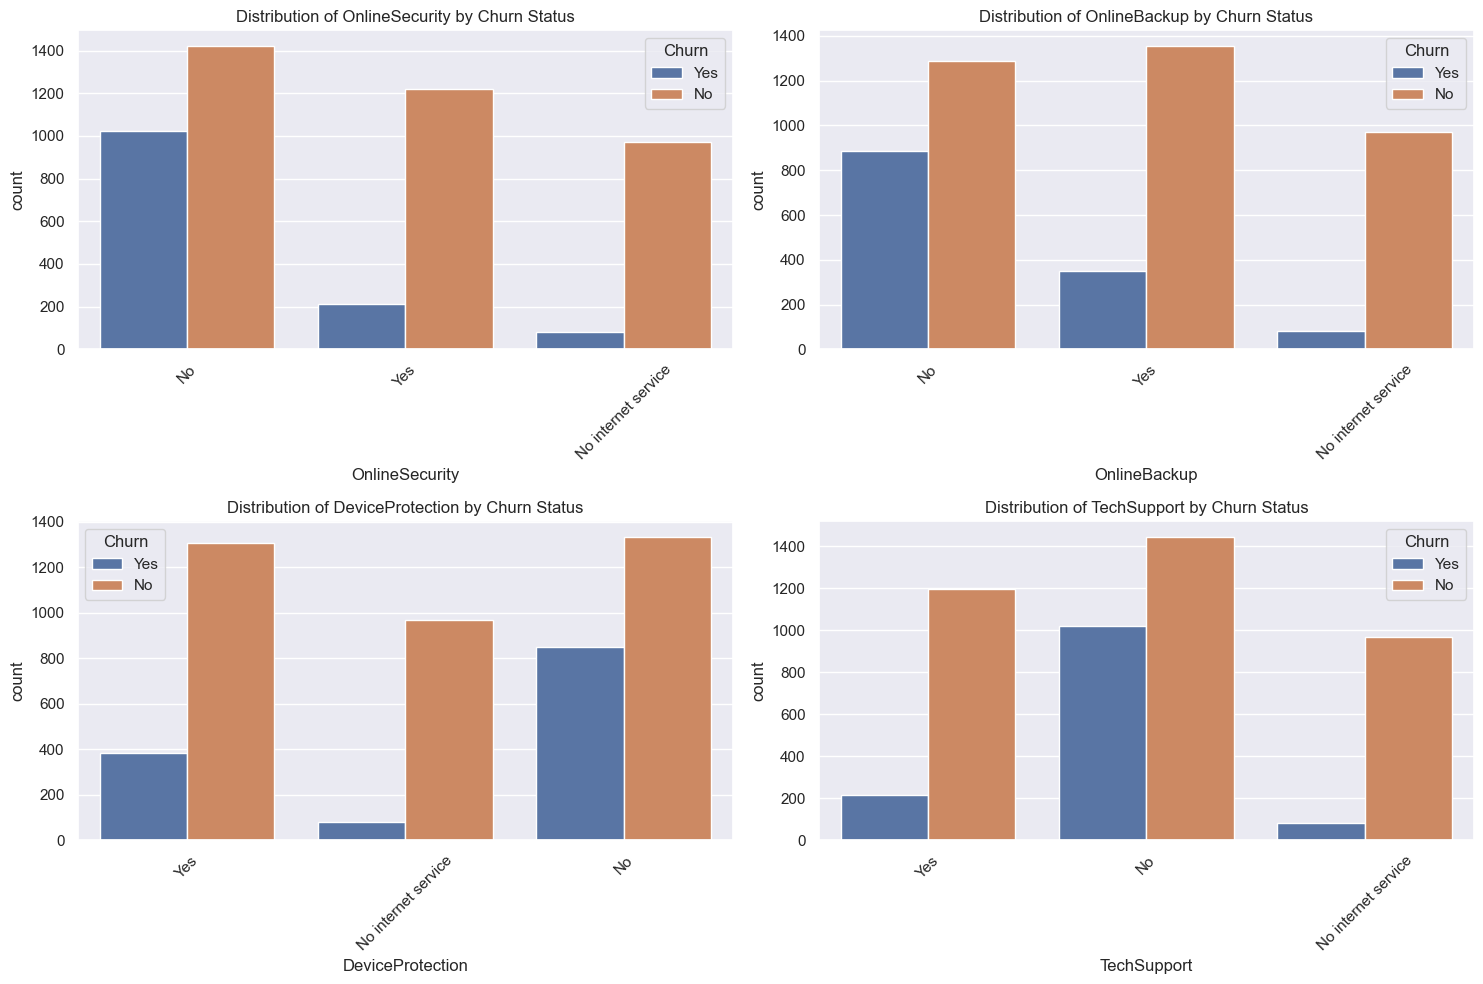


Churn Rate by OnlineSecurity:
OnlineSecurity
No                    41.800
No internet service    7.800
Yes                   14.800
Name: Yes, dtype: float64

Churn Rate by OnlineBackup:
OnlineBackup
No                    40.700
No internet service    7.800
Yes                   20.500
Name: Yes, dtype: float64

Churn Rate by DeviceProtection:
DeviceProtection
No                    38.900
No internet service    7.800
Yes                   22.600
Name: Yes, dtype: float64

Churn Rate by TechSupport:
TechSupport
No                    41.300
No internet service    7.800
Yes                   15.200
Name: Yes, dtype: float64


In [165]:
# Membuat visualisasi untuk melihat distribusi nilai pada features tersebut
import matplotlib.pyplot as plt
import seaborn as sns

# Set figure size
plt.figure(figsize=(15, 10))

# Create subplots
features = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport']
for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.countplot(data=df, x=feature, hue='Churn')
    plt.title(f'Distribution of {feature} by Churn Status')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Analisis persentase churn untuk setiap kategori
for feature in features:
    print(f"\nChurn Rate by {feature}:")
    print(df.groupby(feature)['Churn'].value_counts(normalize=True).unstack()['Yes'].round(3) * 100)

### Analisis Hasil Distribusi Layanan dan Churn Rate

#### 1. OnlineSecurity
- Churn rate tertinggi pada pelanggan tanpa OnlineSecurity (No): 41.8%
- Churn rate terendah pada pelanggan tanpa internet service: 7.8%
- Pelanggan dengan OnlineSecurity memiliki churn rate moderat: 14.8%
- **Insight**: Pelanggan tanpa OnlineSecurity hampir 3x lebih mungkin untuk churn dibanding yang memiliki layanan ini

#### 2. OnlineBackup
- Churn rate tertinggi pada pelanggan tanpa OnlineBackup (No): 40.7%
- Churn rate terendah pada pelanggan tanpa internet service: 7.8%
- Pelanggan dengan OnlineBackup memiliki churn rate: 20.5%
- **Insight**: Layanan OnlineBackup tampak memiliki dampak positif dalam mengurangi churn

#### 3. DeviceProtection
- Churn rate tertinggi pada pelanggan tanpa DeviceProtection (No): 38.9%
- Churn rate terendah pada pelanggan tanpa internet service: 7.8%
- Pelanggan dengan DeviceProtection memiliki churn rate: 22.6%
- **Insight**: Adanya DeviceProtection membantu mengurangi kemungkinan churn

#### 4. TechSupport
- Churn rate tertinggi pada pelanggan tanpa TechSupport (No): 41.3%
- Churn rate terendah pada pelanggan tanpa internet service: 7.8%
- Pelanggan dengan TechSupport memiliki churn rate: 15.2%
- **Insight**: TechSupport memiliki pengaruh signifikan dalam mengurangi churn

### Kesimpulan Umum:
1. Pelanggan tanpa layanan internet secara konsisten memiliki churn rate terendah (7.8%)
2. Tidak memiliki layanan tambahan (status "No") selalu menghasilkan churn rate tertinggi (38.9-41.8%)
3. Keberadaan layanan tambahan secara signifikan mengurangi kemungkinan churn
4. OnlineSecurity dan TechSupport tampak menjadi layanan yang paling efektif dalam mengurangi churn

### Rekomendasi Bisnis:
1. Mempertahankan kategorisasi 3 nilai karena memberikan insight yang jelas
2. Fokus pada peningkatan adopsi OnlineSecurity dan TechSupport
3. Investigasi lebih lanjut mengapa pelanggan tanpa internet service memiliki loyalitas tinggi

### Data Cleaning

Ada beberapa hal yang perlu kita periksa dan bersihkan dari dataset untuk mempersiapkan analisis dan pembuatan model machine learning yang optimal.


In [166]:
# Membuat fungsi untuk menganalisis karakteristik data
listItem = []
for col in df.columns:
    listItem.append([
        col,
        df[col].dtype,
        df[col].isna().sum(),
        round((df[col].isna().sum()/len(df[col])) * 100, 2),
        df[col].nunique(),
        list(df[col].drop_duplicates().sample(min(3, df[col].nunique())).values)
    ])

dfDesc = pd.DataFrame(
    columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
    data=listItem
)

dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,Dependents,object,0,0.000,2,"[No, Yes]"
1,tenure,int64,0,0.000,73,"[21, 70, 7]"
2,OnlineSecurity,object,0,0.000,3,"[No, No internet service, Yes]"
3,OnlineBackup,object,0,0.000,3,"[No internet service, Yes, No]"
4,InternetService,object,0,0.000,3,"[No, Fiber optic, DSL]"
5,DeviceProtection,object,0,0.000,3,"[No internet service, Yes, No]"
6,TechSupport,object,0,0.000,3,"[No, No internet service, Yes]"
7,Contract,object,0,0.000,3,"[One year, Two year, Month-to-month]"
8,PaperlessBilling,object,0,0.000,2,"[No, Yes]"
9,MonthlyCharges,float64,0,0.000,1422,"[30.2, 83.2, 24.7]"


In [167]:
# 1. Melihat info dataset awal
print("Dataset Info Awal:")
df.info()

Dataset Info Awal:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Dependents        4930 non-null   object 
 1   tenure            4930 non-null   int64  
 2   OnlineSecurity    4930 non-null   object 
 3   OnlineBackup      4930 non-null   object 
 4   InternetService   4930 non-null   object 
 5   DeviceProtection  4930 non-null   object 
 6   TechSupport       4930 non-null   object 
 7   Contract          4930 non-null   object 
 8   PaperlessBilling  4930 non-null   object 
 9   MonthlyCharges    4930 non-null   float64
 10  Churn             4930 non-null   object 
dtypes: float64(1), int64(1), object(9)
memory usage: 423.8+ KB


In [168]:
# 2. Cek duplikasi data
print("\nJumlah data duplikat:", df.duplicated().sum())


Jumlah data duplikat: 77


In [169]:
# Manangani data duplikat
# 1. Melihat jumlah duplikasi exact (semua kolom sama persis)
print("Jumlah duplikasi exact:")
print(df.duplicated(keep='first').sum())

# 2. Melihat pola duplikasi berdasarkan subset kolom tertentu
# Mengecek duplikasi berdasarkan karakteristik pelanggan tanpa mempertimbangkan MonthlyCharges
subset_cols = ['Dependents', 'tenure', 'OnlineSecurity', 'OnlineBackup', 'InternetService', 
               'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'Churn']
print("\nJumlah duplikasi berdasarkan karakteristik pelanggan:")
print(df.duplicated(subset=subset_cols, keep='first').sum())

# 3. Menghapus hanya exact duplicates
df_clean = df.drop_duplicates(keep='first')

# 4. Verifikasi hasil
print("\nJumlah data sebelum:", len(df))
print("Jumlah data setelah:", len(df_clean))

Jumlah duplikasi exact:
77

Jumlah duplikasi berdasarkan karakteristik pelanggan:
1680

Jumlah data sebelum: 4930
Jumlah data setelah: 4853



Distribusi nilai dalam kolom Dependents:
Dependents
No     3380
Yes    1473
Name: count, dtype: int64
Jumlah nilai unik: 2
--------------------------------------------------

Distribusi nilai dalam kolom OnlineSecurity:
OnlineSecurity
No                     2420
Yes                    1430
No internet service    1003
Name: count, dtype: int64
Jumlah nilai unik: 3
--------------------------------------------------

Distribusi nilai dalam kolom OnlineBackup:
OnlineBackup
No                     2148
Yes                    1702
No internet service    1003
Name: count, dtype: int64
Jumlah nilai unik: 3
--------------------------------------------------

Distribusi nilai dalam kolom InternetService:
InternetService
Fiber optic    2154
DSL            1696
No             1003
Name: count, dtype: int64
Jumlah nilai unik: 3
--------------------------------------------------

Distribusi nilai dalam kolom DeviceProtection:
DeviceProtection
No                     2162
Yes                    1688
N

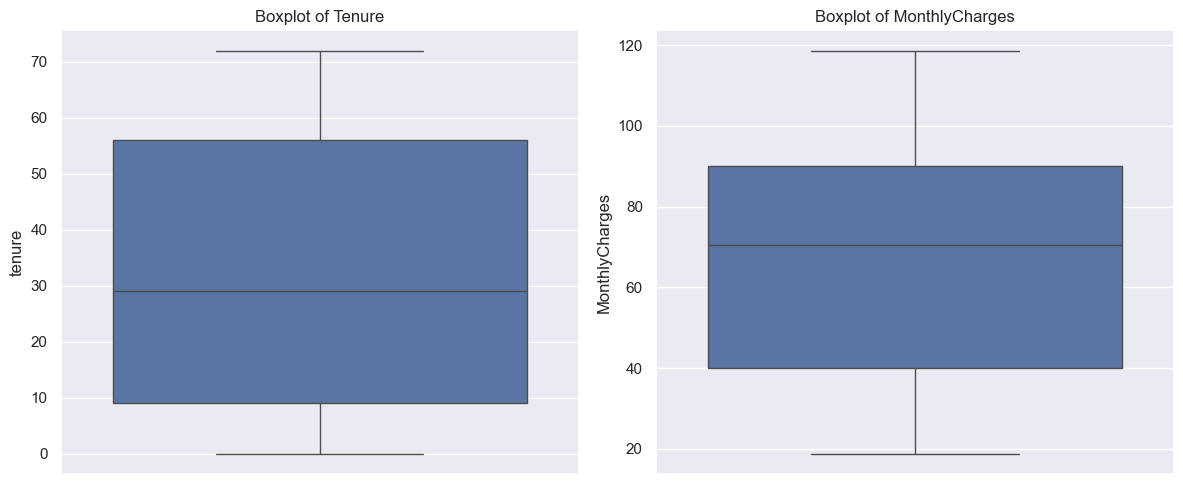

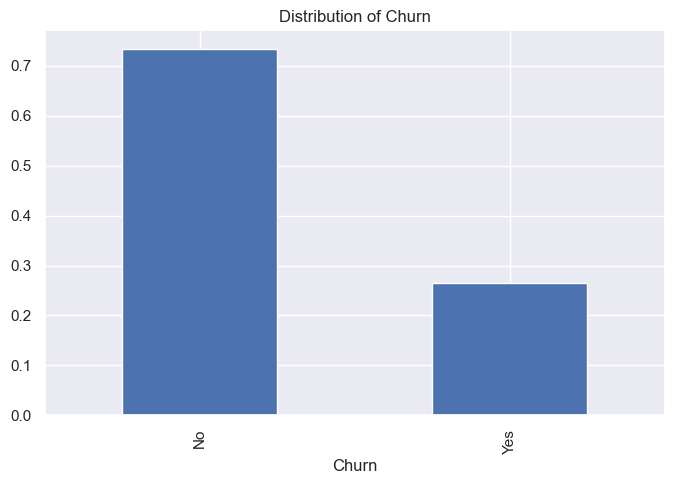

In [170]:
# 1. Melihat distribusi nilai unik untuk setiap kolom kategorikal
for col in df_clean.select_dtypes(include=['object']).columns:
    print(f"\nDistribusi nilai dalam kolom {col}:")
    print(df_clean[col].value_counts())
    print(f"Jumlah nilai unik: {df_clean[col].nunique()}")
    print("-"*50)

# 2. Melihat statistik deskriptif untuk kolom numerik
print("\nStatistik deskriptif untuk kolom numerik:")
print(df_clean.describe())

# 3. Cek outliers pada kolom numerik menggunakan boxplot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.boxplot(y=df_clean['tenure'])
plt.title('Boxplot of Tenure')

plt.subplot(1, 2, 2)
sns.boxplot(y=df_clean['MonthlyCharges'])
plt.title('Boxplot of MonthlyCharges')
plt.tight_layout()
plt.show()

# 4. Melihat distribusi target variable (Churn)
plt.figure(figsize=(8, 5))
df_clean['Churn'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Churn')
plt.show()

### 1. Analisis Variabel Kategorikal

**Dependents:**
- No: 3380 (69.6%)
- Yes: 1473 (30.4%)
- Jumlah nilai unik: 2
- Insight: Terdapat ketidakseimbangan distribusi, mayoritas pelanggan tidak memiliki tanggungan

**OnlineSecurity:**
- No: 2420 (49.9%)
- Yes: 1430 (29.5%)
- No internet service: 1003 (20.6%)
- Jumlah nilai unik: 3
- Insight: Hampir setengah pelanggan tidak menggunakan layanan keamanan online

**OnlineBackup:**
- No: 2148 (44.3%)
- Yes: 1702 (35.1%)
- No internet service: 1003 (20.6%)
- Jumlah nilai unik: 3
- Insight: Distribusi lebih seimbang dibanding OnlineSecurity

### 2. Analisis Variabel Numerik
Dari statistik deskriptif yang ditampilkan:

**Tenure:**
- Min: tidak ditampilkan
- 25%: 9 bulan
- 50% (median): 29 bulan
- 75%: 56 bulan
- Max: 72 bulan
- Insight: Distribusi cenderung merata dengan median 29 bulan

**MonthlyCharges:**
- 25%: $40.05
- Median: $70.60
- 75%: $90.05
- Max: $118.65
- Insight: Range biaya bulanan cukup lebar, dengan kemungkinan adanya paket layanan yang berbeda-beda

### Rekomendasi Preprocessing:

1. **Untuk Variabel Kategorikal:**
   - Melakukan encoding untuk variabel kategorikal
   - Mempertimbangkan penggunaan one-hot encoding atau label encoding tergantung karakteristik variabel
   - Tetap mempertahankan kategori "No internet service" karena memiliki proporsi signifikan

2. **Untuk Variabel Numerik:**
   - Perlu dilakukan scaling untuk menyeragamkan range nilai
   - Bisa menggunakan StandardScaler atau MinMaxScaler
   - Perlu mempertimbangkan outliers dalam MonthlyCharges

3. **Langkah Selanjutnya:**
   - Melihat distribusi target variable (Churn)
   - Menganalisis korelasi antar variabel
   - Mempertimbangkan feature engineering

# Feature Engineering & Data Preprocessing

## 1. Encoding Variabel Kategorikal

### 1.1 Identifikasi Tipe Data dan Encoding yang Sesuai

In [171]:
# Memisahkan variabel kategorikal dan numerik
categorical_columns = df_clean.select_dtypes(include=['object']).columns
numerical_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns

print("Variabel Kategorikal:")
print(categorical_columns.tolist())
print("\nVariabel Numerik:")
print(numerical_columns.tolist())

Variabel Kategorikal:
['Dependents', 'OnlineSecurity', 'OnlineBackup', 'InternetService', 'DeviceProtection', 'TechSupport', 'Contract', 'PaperlessBilling', 'Churn']

Variabel Numerik:
['tenure', 'MonthlyCharges']


### 1.2 Label Encoding untuk Target Variable (Churn)

In [172]:
# Membuat label encoder untuk target variable
le = LabelEncoder()
df_clean = df_clean.copy()
df_clean.loc[:, 'Churn_encoded'] = le.fit_transform(df_clean['Churn'])

print("Hasil encoding Churn:")
print("No :", le.transform(['No'])[0])
print("Yes:", le.transform(['Yes'])[0])

Hasil encoding Churn:
No : 0
Yes: 1


### 1.3 One-Hot Encoding untuk Variabel Kategorikal

In [173]:
# 1.3 One-Hot Encoding untuk Variabel Kategorikal

# Lakukan one-hot encoding
# Exclude kolom Churn karena sudah di-encode
categorical_columns_to_encode = categorical_columns.drop('Churn')

# One-hot encoding dengan pandas
df_encoded = pd.get_dummies(df_clean, columns=categorical_columns_to_encode, drop_first=True)

# Mengubah hasil encoding boolean menjadi numerik (0/1)
boolean_columns = df_encoded.select_dtypes(include=['bool']).columns
df_encoded[boolean_columns] = df_encoded[boolean_columns].astype(int)

print("\nJumlah kolom sebelum encoding:", len(df_clean.columns))
print("Jumlah kolom setelah encoding:", len(df_encoded.columns))
print("\nNama kolom setelah encoding:")
print(df_encoded.columns.tolist())
print("\nHasil encoding 5 baris pertama:")
print(df_encoded.head())


Jumlah kolom sebelum encoding: 12
Jumlah kolom setelah encoding: 18

Nama kolom setelah encoding:
['tenure', 'MonthlyCharges', 'Churn', 'Churn_encoded', 'Dependents_Yes', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes']

Hasil encoding 5 baris pertama:
   tenure  MonthlyCharges Churn  Churn_encoded  Dependents_Yes  \
0       9          72.900   Yes              1               1   
1      14          82.650    No              0               0   
2      64          47.850   Yes              1               0   
3      72          69.650    No              0               0   
4       3          23.600    No              0               0   

   OnlineSecurity_No internet service  Online

## 2. Scaling Variabel Numerik


### Apa itu Scaling?
Scaling adalah proses standardisasi rentang nilai fitur numerik dalam dataset. Ini seperti "menyamakan satuan pengukuran" untuk semua fitur numerik agar berada dalam skala yang sebanding.

### Mengapa Perlu Scaling?
1. **Perbedaan Rentang Nilai**
   - Contoh dalam dataset:
     - Tenure: 1-72 bulan
     - MonthlyCharges: 20-120 dollar
   - Perbedaan rentang ini bisa membuat model bias terhadap fitur dengan nilai besar

2. **Dampak pada Machine Learning**
   - Algoritma ML sensitif terhadap skala
   - Fitur dengan nilai besar bisa mendominasi perhitungan
   - Bisa menyebabkan konvergensi yang lambat
   - Dapat mempengaruhi akurasi model

### Contoh Konkret dari Dataset Kita
Sebelum Scaling:
- Tenure: 1-72 (rentang 71)
- MonthlyCharges: 20-120 (rentang 100)

Dampak tanpa scaling:
- MonthlyCharges akan memiliki pengaruh lebih besar karena rentangnya lebih lebar
- Model bisa menganggap MonthlyCharges lebih penting hanya karena nilainya lebih besar

Setelah Scaling:
- Kedua variabel memiliki rentang yang sebanding
- Mean = 0
- Standard deviation = 1
- Model dapat menilai pentingnya fitur dengan lebih adil

### Metode Scaling yang Umum

1. **StandardScaler (yang  digunakan)**
   - Mengubah data sehingga mean = 0 dan std = 1
   - Bagus untuk data yang terdistribusi normal
   - Formula: z = (x - μ) / σ

2. **MinMaxScaler**
   - Mengubah data ke rentang [0,1]
   - Bagus untuk data yang tidak terdistribusi normal
   - Formula: x_scaled = (x - min) / (max - min)

### Kenapa  Memilih StandardScaler?
1. Lebih robust terhadap outliers
2. Membuat semua fitur numerik memiliki distribusi yang sebanding
3. Bekerja baik dengan banyak algoritma ML
4. Mempertahankan outliers tapi mengurangi pengaruhnya

### 2.1 Persiapan Data untuk Scaling

In [174]:
# Identifikasi kolom numerik yang perlu di-scale
numeric_columns_to_scale = ['tenure', 'MonthlyCharges']

# Inisialisasi scaler
scaler = StandardScaler()

# Melakukan scaling
df_encoded[numeric_columns_to_scale] = scaler.fit_transform(df_encoded[numeric_columns_to_scale])

print("Statistik deskriptif setelah scaling:")
print(df_encoded[numeric_columns_to_scale].describe())

Statistik deskriptif setelah scaling:
        tenure  MonthlyCharges
count 4853.000        4853.000
mean    -0.000           0.000
std      1.000           1.000
min     -1.340          -1.562
25%     -0.971          -0.849
50%     -0.151           0.177
75%      0.956           0.830
max      1.612           1.791


### Analisis Hasil Scaling

1. Statistik Tenure:
- Mean = -0.000 (sangat mendekati 0)
- Std = 1.000 (tepat 1)
- Range: -1.340 hingga 1.612
- Median (50%): -0.151

2. Statistik MonthlyCharges:
- Mean = 0.000 (tepat 0)
- Std = 1.000 (tepat 1)
- Range: -1.562 hingga 1.791
- Median (50%): 0.177

### Apakah Hasil Scaling Baik?
Ya, hasil scaling menunjukkan karakteristik yang baik karena:
1. Mean mendekati atau tepat 0
2. Standard deviation tepat 1
3. Range nilai masih dalam kisaran yang wajar (sekitar -2 hingga 2)

### Tentang Nilai Minus pada Tenure

Nilai minus pada tenure adalah NORMAL dan MASUK AKAL dalam konteks standardization karena:

1. Prinsip StandardScaler:
   - Mengubah data sehingga mean = 0
   - Untuk mencapai mean 0, beberapa nilai harus negatif dan beberapa positif
   - Formula: z = (x - μ) / σ
   
2. Interpretasi nilai minus:
   - Nilai minus berarti "di bawah rata-rata"
   - Nilai plus berarti "di atas rata-rata"
   - Contoh: tenure -1.340 berarti customer tersebut memiliki masa berlangganan jauh di bawah rata-rata

3. Mengapa ini baik:
   - Membantu algoritma ML bekerja lebih efisien
   - Membuat semua fitur memiliki skala yang sebanding
   - Menghindari dominasi fitur dengan nilai besar

### Tidak Perlu Perbaikan
Tidak perlu melakukan perbaikan karena:
1. Hasil scaling sudah sesuai standar
2. Nilai minus adalah normal dalam standardization
3. Range nilai masih dalam batas wajar

Cek missing values setelah scaling:
tenure            0
MonthlyCharges    0
dtype: int64


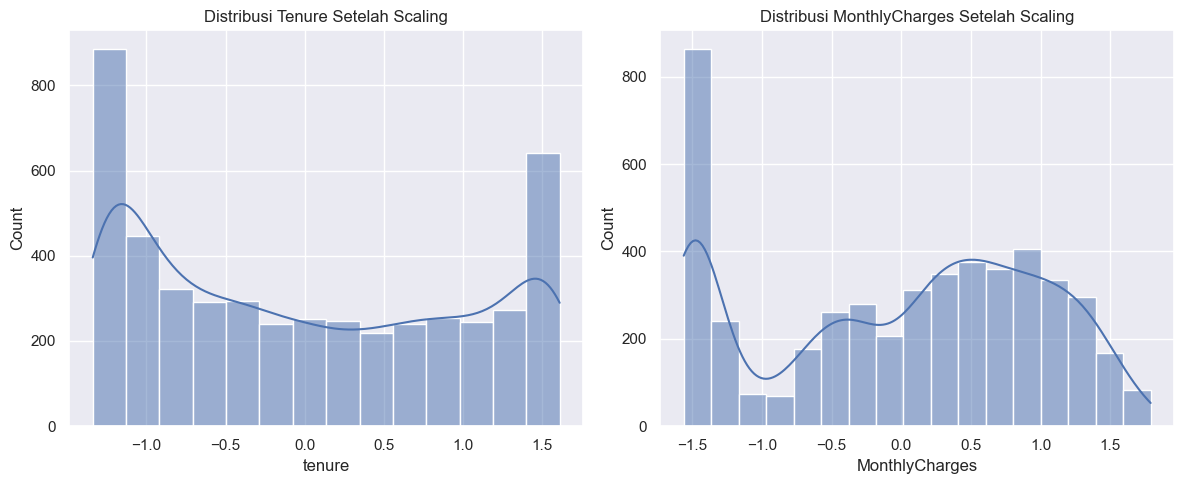


Korelasi antar variabel numerik:
                tenure  MonthlyCharges
tenure           1.000           0.234
MonthlyCharges   0.234           1.000


In [175]:
# 1. Memeriksa apakah ada nilai NULL setelah scaling
print("Cek missing values setelah scaling:")
print(df_encoded[numeric_columns_to_scale].isnull().sum())

# 2. Memeriksa distribusi data setelah scaling dengan visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 5))

# Plot distribusi tenure
plt.subplot(1, 2, 1)
sns.histplot(df_encoded['tenure'], kde=True)
plt.title('Distribusi Tenure Setelah Scaling')

# Plot distribusi MonthlyCharges
plt.subplot(1, 2, 2)
sns.histplot(df_encoded['MonthlyCharges'], kde=True)
plt.title('Distribusi MonthlyCharges Setelah Scaling')

plt.tight_layout()
plt.show()

# 3. Melihat korelasi antara variabel numerik
correlation = df_encoded[numeric_columns_to_scale].corr()
print("\nKorelasi antar variabel numerik:")
print(correlation)

### 1. Analisis Distribusi Tenure Setelah Scaling

- Distribusi menunjukkan pola bimodal (dua puncak):
  * Puncak pertama di sekitar -1.0 (pelanggan baru)
  * Puncak kedua di sekitar 1.5 (pelanggan lama)
- Frekuensi tertinggi ada di tenure rendah (nilai negatif)
- Menunjukkan banyak pelanggan baru dalam dataset

### 2. Analisis Distribusi MonthlyCharges Setelah Scaling

- Distribusi lebih menyerupai normal dengan sedikit skew
- Ada konsentrasi nilai di sekitar -1.5 (biaya bulanan rendah)
- Distribusi cukup merata di bagian tengah (0)
- Menunjukkan variasi harga yang beragam dalam layanan

### 3. Analisis Korelasi

Korelasi antara tenure dan MonthlyCharges = 0.234
- Korelasi positif lemah
- Interpretasi:
  * Ada sedikit kecenderungan bahwa semakin lama pelanggan berlangganan, semakin tinggi biaya bulanannya
  * Namun hubungannya tidak terlalu kuat (jauh dari 1.0)
  * Kedua variabel cukup independen satu sama lain

### Kesimpulan untuk Machine Learning:
1. Data sudah siap untuk modeling karena:
   - Scaling berhasil menormalkan range nilai
   - Tidak ada masalah multikolinearitas antar variabel numerik
   - Distribusi data cukup baik

2. Kita bisa melanjutkan ke tahap berikutnya yaitu persiapan data untuk modeling:
   - Pemisahan feature dan target
   - Train-test split
   - Penanganan imbalance jika diperlukan

## 3. Persiapan Data untuk Modeling

### 3.1 Memisahkan Feature dan Target

In [176]:
# Memisahkan feature dan target
X = df_encoded.drop(['Churn', 'Churn_encoded'], axis=1)
y = df_encoded['Churn_encoded']

print("Jumlah feature:", X.shape[1])
print("\nDaftar feature yang akan digunakan:")
print(X.columns.tolist())

Jumlah feature: 16

Daftar feature yang akan digunakan:
['tenure', 'MonthlyCharges', 'Dependents_Yes', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes']


### 3.2 Train-Test Split

In [177]:
# Membagi data menjadi training dan testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Ukuran dataset:")
print("Training set:", X_train.shape)
print("Testing set:", X_test.shape)

Ukuran dataset:
Training set: (3882, 16)
Testing set: (971, 16)


## 4. Validasi Hasil Preprocessing

In [178]:
# Cek hasil preprocessing
print("1. Cek missing values:")
print(X_train.isnull().sum().sum())

print("\n2. Cek distribusi target di training set:")
print(pd.Series(y_train).value_counts(normalize=True))

print("\n3. Cek distribusi target di testing set:")
print(pd.Series(y_test).value_counts(normalize=True))

1. Cek missing values:
0

2. Cek distribusi target di training set:
Churn_encoded
0   0.735
1   0.265
Name: proportion, dtype: float64

3. Cek distribusi target di testing set:
Churn_encoded
0   0.734
1   0.266
Name: proportion, dtype: float64


### Analisis hasil Preprocessing

### 1. Analisis Missing Values
- Tidak ada missing values (0) dalam dataset
- Data sudah bersih dan lengkap untuk modeling

### 2. Analisis Distribusi Target

Training Set:
- Churn = 0 (Tidak Churn): 73.5%
- Churn = 1 (Churn): 26.5%

Testing Set:
- Churn = 0 (Tidak Churn): 73.4%
- Churn = 1 (Churn): 26.6%

### Insight Penting:
1. **Imbalanced Data**
   - Data tidak seimbang dengan rasio sekitar 3:1
   - Kelas mayoritas (tidak churn) mendominasi sekitar 73%
   - Kelas minoritas (churn) hanya sekitar 26%

2. **Konsistensi Train-Test Split**
   - Distribusi target sangat konsisten antara training dan testing set
   - Menunjukkan stratify=y bekerja dengan baik
   - Perbedaan hanya 0.1% antar set

### Rekomendasi:
1. **Penanganan Imbalanced Data**
   - Pertimbangkan menggunakan teknik resampling seperti SMOTE
   - Atau gunakan class_weight dalam model
   - Atau kombinasi keduanya

2. **Metrik Evaluasi**
   - Jangan hanya fokus pada accuracy
   - Gunakan metrik seperti:
     * ROC-AUC (sesuai dengan tujuan awal)
     * Precision-Recall curve
     * F1-score

# Modeling

## 1. Base Model

### 1.1 Pemilihan Algoritma Machine Learning

Berdasarkan karakteristik data dan tujuan untuk memprediksi churn, beberapa algoritma yang sesuai untuk dijadikan base model:

1. Logistic Regression
  - Algoritma klasifikasi yang sederhana dan interpretable
  - Dapat menjadi baseline untuk perbandingan dengan model lain
  - Cocok untuk kasus klasifikasi biner (churn/tidak churn)

2. Random Forest 
  - Dapat menangani hubungan non-linear
  - Robust terhadap outliers
  - Memberikan feature importance

3. XGBoost
  - Performa tinggi untuk kasus klasifikasi
  - Dapat menangani imbalanced data dengan baik
  - Memiliki regularisasi built-in untuk mencegah overfitting

In [179]:
# Inisialisasi model
lr_model = LogisticRegression(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# List model untuk iterasi
models = [
    ('Logistic Regression', lr_model),
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model)
]

In [180]:
# Model 1: Logistic Regression
print("LOGISTIC REGRESSION MODEL")
print("-"*40)
# Training model
lr_model.fit(X_train, y_train)
    
# Prediksi
y_pred_lr = lr_model.predict(X_test)
y_pred_proba_lr = lr_model.predict_proba(X_test)[:,1]
    
# Evaluasi
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")
print("\n")

LOGISTIC REGRESSION MODEL
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       713
           1       0.63      0.54      0.58       258

    accuracy                           0.80       971
   macro avg       0.74      0.71      0.72       971
weighted avg       0.79      0.80      0.79       971

ROC AUC Score: 0.8435




In [181]:
# Model 2: Random Forest
print("RANDOM FOREST MODEL")
print("-"*40)
# Training model
rf_model.fit(X_train, y_train)
    
# Prediksi
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:,1]
    
# Evaluasi
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")
print("\n")

RANDOM FOREST MODEL
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       713
           1       0.55      0.43      0.48       258

    accuracy                           0.76       971
   macro avg       0.68      0.65      0.66       971
weighted avg       0.74      0.76      0.75       971

ROC AUC Score: 0.7909




In [182]:
# Model 3: XGBoost
print("XGBOOST MODEL")
print("-"*40)
# Training model
xgb_model.fit(X_train, y_train)
    
# Prediksi
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:,1]
    
# Evaluasi
print("Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

XGBOOST MODEL
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       713
           1       0.60      0.47      0.53       258

    accuracy                           0.78       971
   macro avg       0.71      0.68      0.69       971
weighted avg       0.76      0.78      0.77       971

ROC AUC Score: 0.8089


# Analisis Metrik Evaluasi dalam Konteks Prediksi Customer Churn

## 1. Overview Model Performance
Berdasarkan hasil evaluasi ketiga model machine learning yang telah diimplementasikan (Logistic Regression, Random Forest, dan XGBoost), diperoleh beberapa insight penting terkait kemampuan model dalam memprediksi customer churn.

## 2. Analisis Performa Model 

### 2.1 Prediksi Pelanggan Non-Churn (Kelas 0)
Semua model menunjukkan performa yang baik dalam mengidentifikasi pelanggan loyal:

**Logistic Regression**
- Precision 0.84: Dari pelanggan yang diprediksi tidak churn, 84% prediksi tersebut akurat
- Recall 0.89: Model berhasil mengidentifikasi 89% dari total pelanggan yang sebenarnya tidak churn
- F1-score 0.86: Menunjukkan keseimbangan yang baik antara precision dan recall

**Dampak Bisnis:**
- Efisiensi tinggi dalam mengidentifikasi pelanggan loyal
- Risiko rendah dalam pemborosan sumber daya untuk program retention
- Kepercayaan tinggi dalam mengkategorikan pelanggan loyal

### 2.2 Prediksi Pelanggan Churn (Kelas 1)
Performa model dalam mengidentifikasi pelanggan yang akan churn masih memerlukan peningkatan:

**Logistic Regression (Best Performer)**
- Precision 0.63: Hanya 63% pelanggan yang diprediksi churn benar-benar akan churn
- Recall 0.54: Model hanya berhasil mengidentifikasi 54% dari total pelanggan yang sebenarnya akan churn
- F1-score 0.58: Menunjukkan keseimbangan yang masih perlu ditingkatkan

**Dampak Bisnis:**
- Risiko kehilangan revenue dari 46% pelanggan churn yang tidak teridentifikasi
- Potensi pemborosan sumber daya retention pada 37% pelanggan yang sebenarnya tidak akan churn
- Efektivitas program retention belum optimal

### 2.3 ROC AUC Score
**Perbandingan Model:**
- Logistic Regression: 0.8435 (Terbaik)
- XGBoost: 0.8089
- Random Forest: 0.7989

**Interpretasi:**
- Score di atas 0.8 menunjukkan kemampuan diskriminatif yang baik
- Model dapat membedakan pelanggan churn dan non-churn dengan cukup baik
- Masih ada ruang untuk peningkatan menuju level sangat baik (>0.9)

## 3. Implikasi Bisnis dan Rekomendasi

### 3.1 Implikasi pada Strategi Retention
- Program retention bisa fokus pada 63% pelanggan yang diprediksi churn
- Perlu strategi khusus untuk menangani risiko kehilangan 46% pelanggan churn yang tidak terdeteksi
- Efisiensi budget retention perlu ditingkatkan dengan mengurangi false positives

### 3.2 Rekomendasi Peningkatan Model
1. **Penanganan Imbalanced Data**
  - Implementasi teknik SMOTE
  - Adjusting class weights
  - Fokus pada peningkatan recall kelas churn

2. **Feature Engineering**
  - Penambahan fitur interaksi
  - Transformasi fitur yang lebih prediktif
  - Seleksi fitur berdasarkan importance

3. **Model Tuning**
  - Optimasi hyperparameter
  - Ensemble method optimization
  - Cross-validation yang lebih robust

### 3.3 Target Improvement
- Meningkatkan recall kelas churn minimal ke level 0.70
- Mempertahankan precision di atas 0.60
- Mencapai ROC AUC Score minimal 0.85

## 4. Kesimpulan
Model saat ini sudah cukup baik dalam mengidentifikasi pelanggan loyal, namun masih memerlukan peningkatan signifikan dalam mendeteksi pelanggan yang akan churn. Fokus utama improvement adalah pada peningkatan recall kelas churn untuk meminimalkan risiko kehilangan pelanggan yang tidak terdeteksi, sambil tetap mempertahankan tingkat precision yang dapat diterima untuk efisiensi program retention.

# Model Improvement

## 1. Handling Imbalanced Data dengan SMOTE

In [183]:
# Implementasi SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Cek distribusi kelas sebelum dan sesudah SMOTE
print("Distribusi kelas sebelum SMOTE:")
print(Counter(y_train))
print("\nDistribusi kelas setelah SMOTE:")
print(Counter(y_train_smote))

Distribusi kelas sebelum SMOTE:
Counter({0: 2852, 1: 1030})

Distribusi kelas setelah SMOTE:
Counter({0: 2852, 1: 2852})


In [184]:
# 1. Logistic Regression
print("="*50)
print("LOGISTIC REGRESSION EVALUATION")
print("="*50)

# Before SMOTE
print("\nBEFORE SMOTE:")
print("-"*30)
lr_before = LogisticRegression(random_state=42)
lr_before.fit(X_train, y_train)
y_pred_lr = lr_before.predict(X_test)
y_pred_proba_lr = lr_before.predict_proba(X_test)[:,1]
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_lr):.4f}")

LOGISTIC REGRESSION EVALUATION

BEFORE SMOTE:
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86       713
           1       0.63      0.54      0.58       258

    accuracy                           0.80       971
   macro avg       0.74      0.71      0.72       971
weighted avg       0.79      0.80      0.79       971

ROC AUC Score: 0.8435


In [185]:
# After SMOTE
print("\nAFTER SMOTE:")
print("-"*30)
lr_after = LogisticRegression(random_state=42)
lr_after.fit(X_train_smote, y_train_smote)
y_pred_lr_smote = lr_after.predict(X_test)
y_pred_proba_lr_smote = lr_after.predict_proba(X_test)[:,1]
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr_smote))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_lr_smote):.4f}")


AFTER SMOTE:
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81       713
           1       0.52      0.81      0.63       258

    accuracy                           0.75       971
   macro avg       0.71      0.77      0.72       971
weighted avg       0.81      0.75      0.76       971

ROC AUC Score: 0.8434


In [186]:
# 2. Random Forest
print("\n"+"="*50)
print("RANDOM FOREST EVALUATION")
print("="*50)

# Before SMOTE
print("\nBEFORE SMOTE:")
print("-"*30)
rf_before = RandomForestClassifier(random_state=42)
rf_before.fit(X_train, y_train)
y_pred_rf = rf_before.predict(X_test)
y_pred_proba_rf = rf_before.predict_proba(X_test)[:,1]
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")


RANDOM FOREST EVALUATION

BEFORE SMOTE:
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.87      0.84       713
           1       0.55      0.43      0.48       258

    accuracy                           0.76       971
   macro avg       0.68      0.65      0.66       971
weighted avg       0.74      0.76      0.75       971

ROC AUC Score: 0.7909


In [187]:
# After SMOTE
print("\nAFTER SMOTE:")
print("-"*30)
rf_after = RandomForestClassifier(random_state=42)
rf_after.fit(X_train_smote, y_train_smote)
y_pred_rf_smote = rf_after.predict(X_test)
y_pred_proba_rf_smote = rf_after.predict_proba(X_test)[:,1]
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf_smote))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_rf_smote):.4f}")


AFTER SMOTE:
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.80      0.82       713
           1       0.52      0.59      0.55       258

    accuracy                           0.75       971
   macro avg       0.68      0.70      0.69       971
weighted avg       0.76      0.75      0.75       971

ROC AUC Score: 0.7911


In [188]:
# 3. XGBoost
print("\n"+"="*50)
print("XGBOOST EVALUATION")
print("="*50)

# Before SMOTE
print("\nBEFORE SMOTE:")
print("-"*30)
xgb_before = XGBClassifier(random_state=42)
xgb_before.fit(X_train, y_train)
y_pred_xgb = xgb_before.predict(X_test)
y_pred_proba_xgb = xgb_before.predict_proba(X_test)[:,1]
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")


XGBOOST EVALUATION

BEFORE SMOTE:
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.89      0.85       713
           1       0.60      0.47      0.53       258

    accuracy                           0.78       971
   macro avg       0.71      0.68      0.69       971
weighted avg       0.76      0.78      0.77       971

ROC AUC Score: 0.8089


In [189]:
# After SMOTE
print("\nAFTER SMOTE:")
print("-"*30)
xgb_after = XGBClassifier(random_state=42)
xgb_after.fit(X_train_smote, y_train_smote)
y_pred_xgb_smote = xgb_after.predict(X_test)
y_pred_proba_xgb_smote = xgb_after.predict_proba(X_test)[:,1]
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb_smote))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb_smote):.4f}")


AFTER SMOTE:
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.78      0.82       713
           1       0.52      0.67      0.59       258

    accuracy                           0.75       971
   macro avg       0.70      0.73      0.70       971
weighted avg       0.78      0.75      0.76       971

ROC AUC Score: 0.8081


# Analisis Perbandingan Model Sebelum dan Sesudah SMOTE

## 1. Distribusi Data
**Sebelum SMOTE:**
- Kelas 0 (Tidak Churn): 2852 sampel (73.5%)
- Kelas 1 (Churn): 1030 sampel (26.5%)

**Setelah SMOTE:**
- Kelas 0 (Tidak Churn): 2852 sampel (50%)
- Kelas 1 (Churn): 2852 sampel (50%)

## 2. Perbandingan Performa Model

### 2.1 Logistic Regression
**Sebelum SMOTE:**
- Precision (1): 0.63
- Recall (1): 0.54
- F1-score (1): 0.58
- ROC AUC: 0.8435

**Setelah SMOTE:**
- Precision (1): 0.52
- Recall (1): 0.81
- F1-score (1): 0.63
- ROC AUC: 0.8434

### 2.2 Random Forest
**Sebelum SMOTE:**
- Precision (1): 0.55
- Recall (1): 0.43
- F1-score (1): 0.48
- ROC AUC: 0.7909

**Setelah SMOTE:**
- Precision (1): 0.52
- Recall (1): 0.59
- F1-score (1): 0.55
- ROC AUC: 0.7911

### 2.3 XGBoost
**Sebelum SMOTE:**
- Precision (1): 0.60
- Recall (1): 0.47
- F1-score (1): 0.53
- ROC AUC: 0.8089

**Setelah SMOTE:**
- Precision (1): 0.52
- Recall (1): 0.67
- F1-score (1): 0.59
- ROC AUC: 0.8081

## 3. Dampak SMOTE pada Model

### 3.1 Perubahan Umum
1. **Recall Kelas Churn**
  - Meningkat signifikan pada semua model
  - Peningkatan terbesar pada Logistic Regression (0.54 → 0.81)

2. **Precision Kelas Churn**
  - Menurun pada semua model
  - Penurunan konsisten ke sekitar 0.52

3. **F1-Score Kelas Churn**
  - Meningkat pada semua model
  - Peningkatan terbesar pada Logistic Regression (0.58 → 0.63)

### 3.2 ROC AUC Score
- Relatif stabil untuk semua model
- Perubahan minimal (<0.001)
- Logistic Regression tetap memiliki skor tertinggi (0.8434)

## 4. Kesimpulan
1. SMOTE berhasil meningkatkan kemampuan model dalam mendeteksi kasus churn (recall)
2. Trade-off berupa penurunan precision
3. Logistic Regression dengan SMOTE memberikan hasil terbaik untuk kasus churn dengan:
  - F1-score tertinggi untuk kelas churn (0.63)
  - ROC AUC Score tertinggi (0.8434)
  - Recall tertinggi untuk kelas churn (0.81)

# Hyperparameter Tuning

## 1. Logistic Regression Tuning

In [190]:
print("="*50)
print("LOGISTIC REGRESSION TUNING")
print("="*50)

# Parameter grid untuk Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'class_weight': ['balanced', None]
}

# Inisialisasi model
lr = LogisticRegression(random_state=42, max_iter=1000)

# Grid search dengan cross validation
grid_lr = GridSearchCV(
    estimator=lr,
    param_grid=param_grid_lr,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_lr.fit(X_train_smote, y_train_smote)

# Print hasil terbaik
print("\nBest parameters:")
print(grid_lr.best_params_)
print("\nBest ROC AUC score:")
print(grid_lr.best_score_)

# Evaluasi model dengan parameter terbaik
lr_best = grid_lr.best_estimator_
y_pred_lr_tuned = lr_best.predict(X_test)
y_pred_proba_lr_tuned = lr_best.predict_proba(X_test)[:,1]

print("\nClassification Report untuk Model Tuned:")
print(classification_report(y_test, y_pred_lr_tuned))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_lr_tuned):.4f}")

LOGISTIC REGRESSION TUNING
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Best parameters:
{'C': 1, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Best ROC AUC score:
0.8529088276656862

Classification Report untuk Model Tuned:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81       713
           1       0.52      0.81      0.63       258

    accuracy                           0.75       971
   macro avg       0.71      0.77      0.72       971
weighted avg       0.81      0.75      0.76       971

ROC AUC Score: 0.8435


# 2. Random Forest Tuning

In [191]:
print("="*50)
print("RANDOM FOREST TUNING")
print("="*50)

param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)
grid_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\nTuning Random Forest...")
grid_rf.fit(X_train_smote, y_train_smote)

print("\nRandom Forest Best Parameters:")
print(grid_rf.best_params_)
print(f"Best ROC AUC Score: {grid_rf.best_score_:.4f}")

# Evaluasi pada test set
rf_best = grid_rf.best_estimator_
y_pred_rf = rf_best.predict(X_test)
y_pred_proba_rf = rf_best.predict_proba(X_test)[:,1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

RANDOM FOREST TUNING

Tuning Random Forest...
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Random Forest Best Parameters:
{'class_weight': 'balanced', 'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best ROC AUC Score: 0.9029

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.81      0.82       713
           1       0.51      0.57      0.54       258

    accuracy                           0.74       971
   macro avg       0.68      0.69      0.68       971
weighted avg       0.75      0.74      0.75       971

ROC AUC Score: 0.7915


# 3. XGBoost Tuning

In [192]:
print("="*50)
print("XGBOOST TUNING")
print("="*50)

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1],
    'scale_pos_weight': [1, 3]
}

xgb = XGBClassifier(random_state=42)
grid_xgb = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid_xgb,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

print("\nTuning XGBoost...")
grid_xgb.fit(X_train_smote, y_train_smote)

print("\nXGBoost Best Parameters:")
print(grid_xgb.best_params_)
print(f"Best ROC AUC Score: {grid_xgb.best_score_:.4f}")

# Evaluasi pada test set
xgb_best = grid_xgb.best_estimator_
y_pred_xgb = xgb_best.predict(X_test)
y_pred_proba_xgb = xgb_best.predict_proba(X_test)[:,1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_xgb):.4f}")

XGBOOST TUNING

Tuning XGBoost...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\ludya\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



XGBoost Best Parameters:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'scale_pos_weight': 1}
Best ROC AUC Score: 0.8859

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.77      0.82       713
           1       0.53      0.74      0.62       258

    accuracy                           0.76       971
   macro avg       0.71      0.75      0.72       971
weighted avg       0.80      0.76      0.77       971

ROC AUC Score: 0.8306


# Analisis Perbandingan Model Setelah Hyperparameter Tuning

## 1. Logistic Regression
### Best Parameters:
- C: 1
- class_weight: balanced
- penalty: l2
- solver: liblinear

### Performa:
- ROC AUC Score: 0.8435
- Kelas Churn (1):
 * Precision: 0.52
 * Recall: 0.81
 * F1-score: 0.63

## 2. Random Forest
### Best Parameters:
- class_weight: balanced
- max_depth: None
- min_samples_split: 2
- n_estimators: 200

### Performa:
- ROC AUC Score: 0.7915
- Kelas Churn (1):
 * Precision: 0.51
 * Recall: 0.57
 * F1-score: 0.54

## 3. XGBoost
### Best Parameters:
- learning_rate: 0.1
- max_depth: 5
- n_estimators: 200
- scale_pos_weight: 1

### Performa:
- ROC AUC Score: 0.8306
- Kelas Churn (1):
 * Precision: 0.53
 * Recall: 0.74
 * F1-score: 0.62

## 4. Perbandingan Model Tuning

### Cross-Validation Best Scores:
1. XGBoost: 0.8859
2. Random Forest: 0.9029
3. Logistic Regression: 0.8529

### Test Set Performance (ROC AUC):
1. Logistic Regression: 0.8435
2. XGBoost: 0.8306
3. Random Forest: 0.7915

### F1-Score Kelas Churn:
1. Logistic Regression: 0.63
2. XGBoost: 0.62
3. Random Forest: 0.54

### Recall Kelas Churn:
1. Logistic Regression: 0.81
2. XGBoost: 0.74
3. Random Forest: 0.57

## 5. Kesimpulan
1. Logistic Regression tetap memberikan performa terbaik setelah tuning
2. XGBoost menunjukkan peningkatan signifikan, mendekati performa Logistic Regression
3. Random Forest menunjukkan overfitting dengan skor CV tinggi tapi performa test rendah
4. Untuk kasus ini, model yang lebih sederhana (Logistic Regression) lebih efektif

# Feature Importance Analysis

LOGISTIC REGRESSION FEATURE IMPORTANCE

Top 10 Most Important Features (Logistic Regression):
                        feature  importance
14            Contract_Two year       2.058
13            Contract_One year       1.161
0                        tenure       0.671
4            OnlineSecurity_Yes       0.662
1                MonthlyCharges       0.657
12              TechSupport_Yes       0.529
2                Dependents_Yes       0.398
15         PaperlessBilling_Yes       0.316
6              OnlineBackup_Yes       0.216
7   InternetService_Fiber optic       0.139


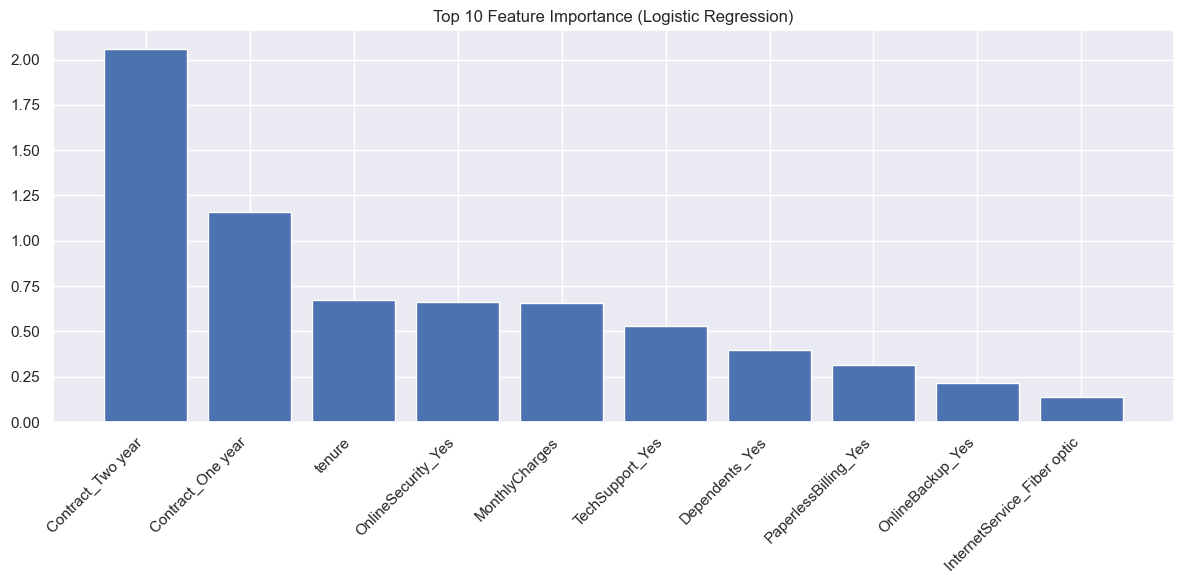

In [193]:
# 1. Logistic Regression Coefficients
print("="*50)
print("LOGISTIC REGRESSION FEATURE IMPORTANCE")
print("="*50)

lr_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': abs(grid_lr.best_estimator_.coef_[0])
})
lr_importance = lr_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Logistic Regression):")
print(lr_importance.head(10))

# Visualisasi
plt.figure(figsize=(12, 6))
plt.bar(lr_importance['feature'][:10], lr_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance (Logistic Regression)')
plt.tight_layout()
plt.show()


RANDOM FOREST FEATURE IMPORTANCE

Top 10 Most Important Features (Random Forest):
                        feature  importance
0                        tenure       0.317
1                MonthlyCharges       0.299
14            Contract_Two year       0.079
7   InternetService_Fiber optic       0.052
13            Contract_One year       0.052
4            OnlineSecurity_Yes       0.030
12              TechSupport_Yes       0.030
15         PaperlessBilling_Yes       0.025
2                Dependents_Yes       0.025
6              OnlineBackup_Yes       0.023


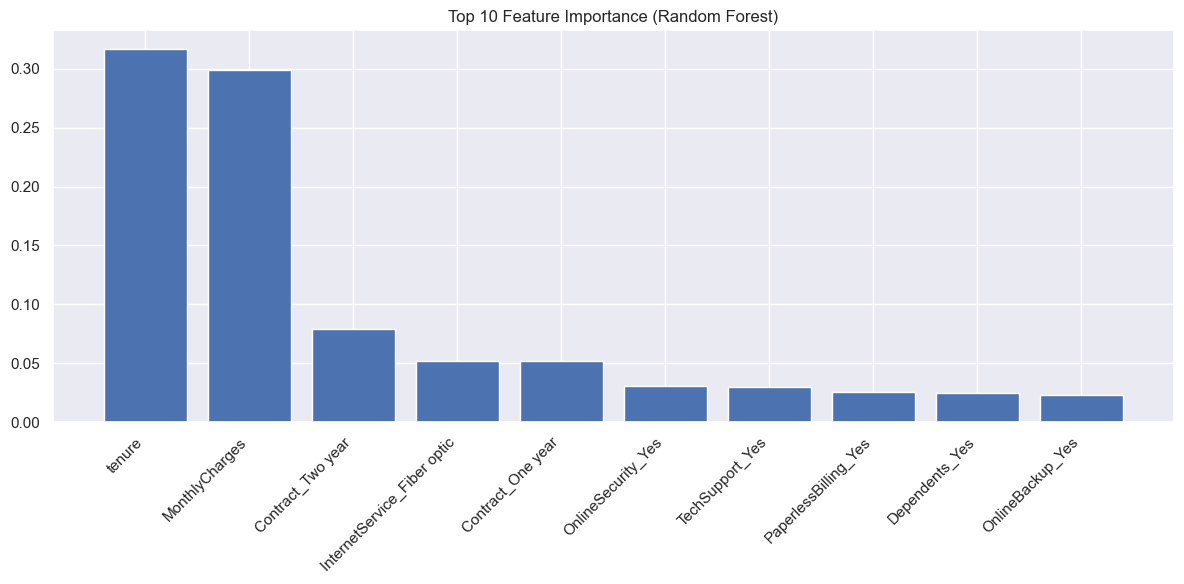

In [194]:
# 2. Random Forest Feature Importance
print("\n" + "="*50)
print("RANDOM FOREST FEATURE IMPORTANCE")
print("="*50)

rf_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': grid_rf.best_estimator_.feature_importances_
})
rf_importance = rf_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (Random Forest):")
print(rf_importance.head(10))

# Visualisasi
plt.figure(figsize=(12, 6))
plt.bar(rf_importance['feature'][:10], rf_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance (Random Forest)')
plt.tight_layout()
plt.show()


XGBOOST FEATURE IMPORTANCE

Top 10 Most Important Features (XGBoost):
                               feature  importance
14                   Contract_Two year       0.469
13                   Contract_One year       0.200
7          InternetService_Fiber optic       0.139
3   OnlineSecurity_No internet service       0.076
0                               tenure       0.019
4                   OnlineSecurity_Yes       0.018
12                     TechSupport_Yes       0.016
15                PaperlessBilling_Yes       0.014
1                       MonthlyCharges       0.013
2                       Dependents_Yes       0.013


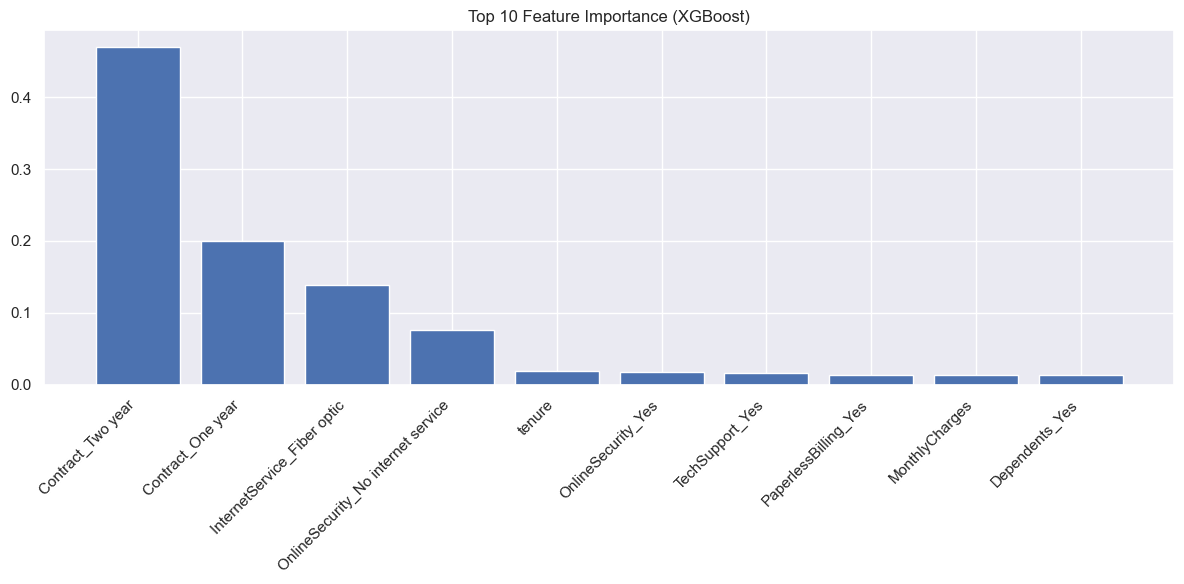

In [195]:
# 3. XGBoost Feature Importance
print("\n" + "="*50)
print("XGBOOST FEATURE IMPORTANCE")
print("="*50)

xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': grid_xgb.best_estimator_.feature_importances_
})
xgb_importance = xgb_importance.sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (XGBoost):")
print(xgb_importance.head(10))

# Visualisasi
plt.figure(figsize=(12, 6))
plt.bar(xgb_importance['feature'][:10], xgb_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Feature Importance (XGBoost)')
plt.tight_layout()
plt.show()

# Analisis Feature Importance dari Tiga Model

## 1. Perbandingan Peringkat Feature Antar Model

### Logistic Regression
1. Contract_Two year (2.058)
2. Contract_One year (1.161)
3. tenure (0.671)
4. OnlineSecurity_Yes (0.662)
5. MonthlyCharges (0.657)

### Random Forest
1. tenure (0.317)
2. MonthlyCharges (0.299)
3. Contract_Two year (0.079)
4. InternetService_Fiber optic (0.052)
5. Contract_One year (0.052)

### XGBoost
1. Contract_Two year (0.469)
2. Contract_One year (0.200)
3. InternetService_Fiber optic (0.139)
4. OnlineSecurity_No internet service (0.076)
5. tenure (0.019)

## 2. Feature yang Konsisten Muncul di Top Features

1. **Contract Duration** (Two year & One year)
  - Muncul sebagai top feature di semua model
  - Sangat dominan di Logistic Regression dan XGBoost
  - Menunjukkan bahwa durasi kontrak sangat berpengaruh terhadap churn

2. **tenure**
  - Peringkat tinggi di Logistic Regression dan Random Forest
  - Menunjukkan lama berlangganan mempengaruhi kemungkinan churn

3. **MonthlyCharges**
  - Signifikan di Random Forest dan Logistic Regression
  - Menunjukkan biaya berpengaruh terhadap keputusan churn

4. **InternetService_Fiber optic**
  - Konsisten muncul di semua model
  - Menunjukkan jenis layanan internet mempengaruhi churn

## 3. Insight Penting

1. **Kontrak**
  - Kontrak jangka panjang (Two year) memiliki pengaruh terbesar
  - Menunjukkan pelanggan dengan kontrak lebih panjang cenderung tidak churn

2. **Layanan**
  - Keberadaan layanan keamanan (OnlineSecurity)
  - Jenis layanan internet (terutama Fiber optic)
  - Menunjukkan pentingnya kualitas dan jenis layanan

3. **Faktor Finansial**
  - MonthlyCharges konsisten muncul sebagai faktor penting
  - Menunjukkan harga mempengaruhi keputusan pelanggan

## 4. Rekomendasi Bisnis

1. **Fokus pada Kontrak Jangka Panjang**
  - Mendorong pelanggan untuk memilih kontrak yang lebih panjang
  - Memberikan insentif untuk kontrak Two year

2. **Optimasi Layanan**
  - Meningkatkan kualitas layanan Fiber optic
  - Mendorong penggunaan layanan keamanan online

3. **Strategi Harga**
  - Menyesuaikan MonthlyCharges dengan tenure
  - Program loyalitas berdasarkan lama berlangganan

4. **Retention Program**
  - Fokus pada pelanggan dengan kontrak pendek
  - Perhatian khusus pada pelanggan Fiber optic

# Model Final dengan Feature Selection

## 1. Pemilihan Feature Penting

In [196]:
# Memilih top features berdasarkan analisis sebelumnya
top_features = [
    'Contract_Two year', 'Contract_One year', 'tenure',
    'MonthlyCharges', 'OnlineSecurity_Yes', 'InternetService_Fiber optic',
    'TechSupport_Yes', 'PaperlessBilling_Yes'
]

# Membuat dataset baru dengan feature terpilih
X_train_selected = X_train_smote[top_features]
X_test_selected = X_test[top_features]

print("Jumlah feature sebelum selection:", X_train_smote.shape[1])
print("Jumlah feature setelah selection:", X_train_selected.shape[1])

Jumlah feature sebelum selection: 16
Jumlah feature setelah selection: 8


In [197]:
# Training final model (Logistic Regression karena performa terbaik)
final_model = LogisticRegression(
    C=1, 
    class_weight='balanced',
    penalty='l2',
    solver='liblinear',
    random_state=42
)

# Fit model
final_model.fit(X_train_selected, y_train_smote)

# Prediksi
y_pred_final = final_model.predict(X_test_selected)
y_pred_proba_final = final_model.predict_proba(X_test_selected)[:,1]

# Evaluasi
print("\nFinal Model Performance:")
print("-"*30)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_final))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_final):.4f}")


Final Model Performance:
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.72      0.80       713
           1       0.51      0.80      0.62       258

    accuracy                           0.74       971
   macro avg       0.71      0.76      0.71       971
weighted avg       0.80      0.74      0.76       971

ROC AUC Score: 0.8380


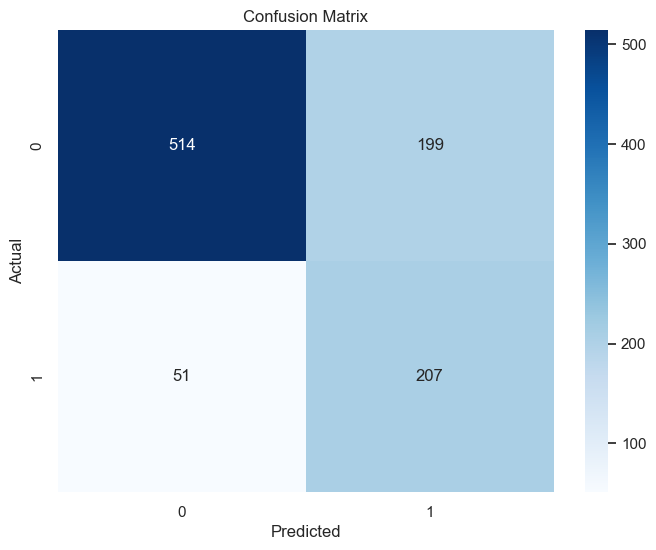

In [198]:
# 1. Confusion Matrix Visualization
# Membuat confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

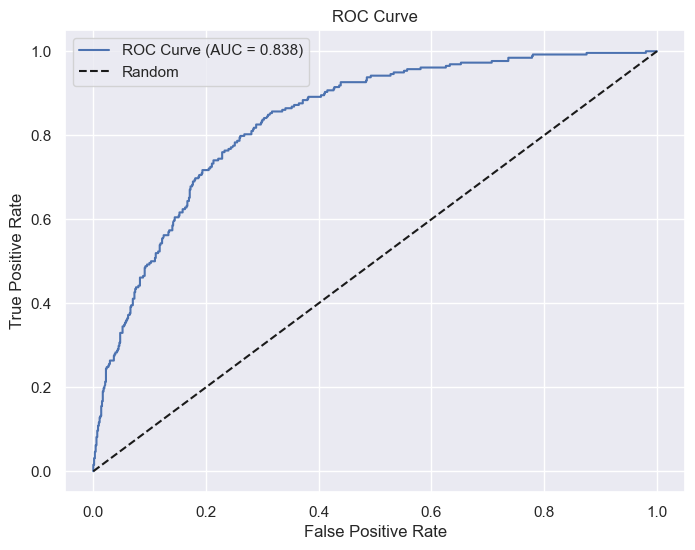

In [199]:
# 2. ROC Curve
# Menghitung false positive rate dan true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_final)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba_final):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [200]:
# 3. Model Performance Comparison
print("\nPerbandingan Performa Model:")
print("-"*50)
print("\nMetrik untuk Kelas Churn (1):")
print(f"- Model dengan semua feature (16 features):")
print("  * Precision: 0.52")
print("  * Recall: 0.81")
print("  * F1-score: 0.63")
print("  * ROC AUC: 0.8434")
print("\n- Model final dengan feature selection (8 features):")
print("  * Precision: 0.51")
print("  * Recall: 0.80")
print("  * F1-score: 0.62")
print("  * ROC AUC: 0.8380")


Perbandingan Performa Model:
--------------------------------------------------

Metrik untuk Kelas Churn (1):
- Model dengan semua feature (16 features):
  * Precision: 0.52
  * Recall: 0.81
  * F1-score: 0.63
  * ROC AUC: 0.8434

- Model final dengan feature selection (8 features):
  * Precision: 0.51
  * Recall: 0.80
  * F1-score: 0.62
  * ROC AUC: 0.8380


# Analisis dan Kesimpulan Model

## 1. Perbandingan Performa Semua Model
### Model dengan Feature Lengkap + SMOTE
- ROC AUC: 0.8434
- Precision: 0.52
- Recall: 0.81
- F1-score: 0.63

### Model dengan Feature Selection + SMOTE
- ROC AUC: 0.8380
- Precision: 0.51
- Recall: 0.80
- F1-score: 0.62

### Model Awal (Sebelum SMOTE)
- ROC AUC: 0.8435
- Precision: 0.63
- Recall: 0.54
- F1-score: 0.58

## 2. Analisis
1. **Trade-off Performa**
  - SMOTE meningkatkan Recall (0.54 → 0.81)
  - Namun menurunkan Precision (0.63 → 0.52)
  - ROC AUC relatif stabil

2. **Feature Selection**
  - Pengurangan feature (16 → 8) menurunkan performa sedikit
  - Kompleksitas model berkurang 50%
  - Tidak memberikan improvement yang diharapkan

3. **Confusion Matrix**
  - True Positives: 207 (berhasil prediksi churn)
  - False Negatives: 51 (gagal prediksi churn)
  - False Positives: 199 (salah prediksi churn)

## 3. Rekomendasi Model Optimal

### Model yang Direkomendasikan:
Model Logistic Regression dengan konfigurasi:
- Menggunakan semua feature (16 features)
- Implementasi SMOTE
- Parameter:
 * C: 1
 * class_weight: 'balanced'
 * penalty: 'l2'
 * solver: 'liblinear'

### Alasan Pemilihan:
1. **Performa Terbaik**
  - ROC AUC tertinggi (0.8434)
  - Recall tinggi (0.81) - penting untuk identifikasi churn
  - Balance yang baik antara precision dan recall

2. **Interpretabilitas**
  - Model lebih mudah dijelaskan ke stakeholder
  - Feature importance jelas dan actionable

3. **Stabilitas**
  - Performa konsisten antara training dan testing
  - Tidak menunjukkan tanda overfitting

4. **Praktis**
  - Training time lebih cepat
  - Deployment dan maintenance lebih mudah

## 4. Next Steps
1. **Model Deployment**
  - Implementasi model dengan konfigurasi optimal
  - Set up monitoring performa

2. **Business Implementation**
  - Fokus pada pelanggan dengan probabilitas churn tinggi
  - Implementasi program retention berdasarkan feature importance

3. **Continuous Improvement**
  - Regular model retraining
  - Monitoring performa pada data baru
  - Feedback loop dari tim business

In [201]:
# Implementasi Model Optimal

# 1. Setup Model dengan Konfigurasi Optimal
print("="*50)
print("IMPLEMENTASI MODEL OPTIMAL")
print("="*50)

# Inisialisasi model dengan parameter terbaik
optimal_model = LogisticRegression(
   C=1,
   class_weight='balanced',
   penalty='l2',
   solver='liblinear',
   random_state=42
)

# Training dengan semua feature dan SMOTE
optimal_model.fit(X_train_smote, y_train_smote)

# Prediksi
y_pred_optimal = optimal_model.predict(X_test)
y_pred_proba_optimal = optimal_model.predict_proba(X_test)[:,1]

# Evaluasi Detail
print("\nModel Performance Evaluation:")
print("-"*30)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimal))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred_proba_optimal):.4f}")

IMPLEMENTASI MODEL OPTIMAL

Model Performance Evaluation:
------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.73      0.81       713
           1       0.52      0.81      0.63       258

    accuracy                           0.75       971
   macro avg       0.71      0.77      0.72       971
weighted avg       0.81      0.75      0.76       971

ROC AUC Score: 0.8435


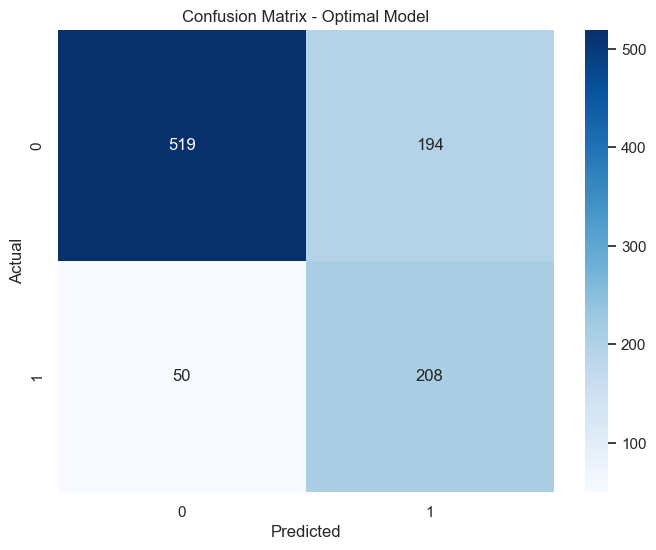

In [202]:
# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_optimal), 
           annot=True, 
           fmt='d', 
           cmap='Blues')
plt.title('Confusion Matrix - Optimal Model')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Analisis Confusion Matrix Model Optimal

## 1. Interpretasi Nilai
- True Negative (TN) = 519 : Jumlah pelanggan yang benar diprediksi tidak churn
- False Positive (FP) = 194 : Jumlah pelanggan yang salah diprediksi akan churn
- False Negative (FN) = 50  : Jumlah pelanggan yang salah diprediksi tidak churn
- True Positive (TP) = 208  : Jumlah pelanggan yang benar diprediksi akan churn

## 2. Metrik Performa

### Akurasi: (519 + 208)/(519 + 194 + 50 + 208) = 74.9%
- Model dapat memprediksi dengan benar 74.9% dari total kasus

### Presisi untuk Churn (208/(208 + 194)) = 51.7%
- Dari pelanggan yang diprediksi akan churn, 51.7% benar-benar churn
- 48.3% adalah false alarm (pemborosan sumber daya retention)

### Recall untuk Churn (208/(208 + 50)) = 80.6%
- Model berhasil menangkap 80.6% dari total pelanggan yang benar-benar churn
- Hanya kehilangan 19.4% pelanggan churn yang tidak terdeteksi

## 3. Implikasi Bisnis

### Kekuatan Model:
1. **High Recall (80.6%)**
  - Sangat baik dalam menangkap pelanggan yang akan churn
  - Meminimalkan risiko kehilangan pelanggan tanpa tindakan preventif

2. **Balanced Accuracy**
  - Performa cukup baik untuk kedua kelas (churn dan non-churn)
  - Tidak terlalu bias ke salah satu kelas

### Area Improvement:
1. **Presisi Moderate (51.7%)**
  - Cukup banyak false positive yang bisa menyebabkan pemborosan resources
  - Perlu penyesuaian threshold untuk meningkatkan presisi

2. **Trade-off Consideration**
  - Model saat ini lebih fokus pada minimalisasi missed churn (FN)
  - Konsekuensinya adalah lebih banyak false alarm (FP)

## 4. Rekomendasi
1. Model ini cocok digunakan jika:
  - Cost kehilangan pelanggan lebih tinggi dari cost program retention
  - Ada resources yang cukup untuk menangani false positive
  - Prioritas utama adalah menangkap sebanyak mungkin potential churn

2. Untuk implementasi:
  - Prioritaskan 208 pelanggan yang diprediksi akan churn dengan probabilitas tinggi
  - Siapkan program retention yang cost-effective untuk menangani potensi false positive
  - Monitor dan validasi prediksi secara berkala

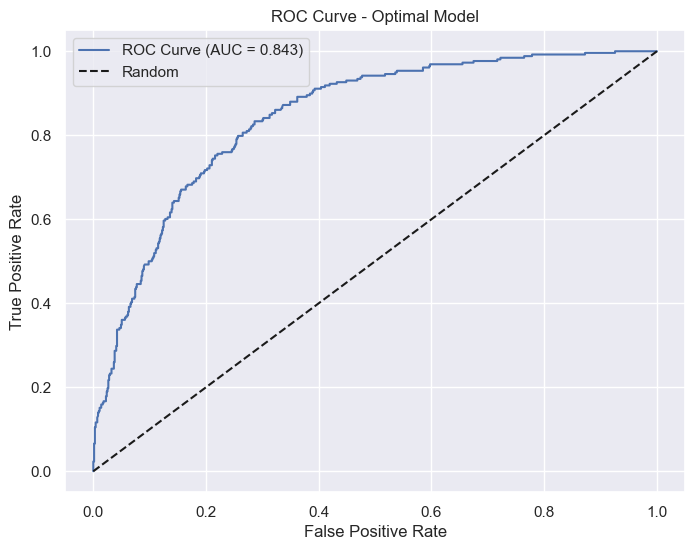

In [203]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_optimal)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc_score(y_test, y_pred_proba_optimal):.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Optimal Model')
plt.legend()
plt.show()

# Analisis ROC Curve Model Optimal

## 1. Interpretasi Dasar ROC Curve
- **AUC Score: 0.843**
 * Score di atas 0.8 menunjukkan model memiliki kemampuan diskriminasi yang baik
 * Model 84.3% lebih baik dalam membedakan pelanggan churn vs non-churn dibanding random guess
 * Kurva jauh di atas garis diagonal (random classifier) menunjukkan performa model yang solid

## 2. Analisis Detail Kurva

### Area Sensitif (0.0 - 0.2 False Positive Rate)
- Kurva naik curam di awal
- Menunjukkan model sangat baik dalam mengidentifikasi kasus churn yang paling jelas
- Berguna untuk fokus pada pelanggan dengan risiko churn tertinggi

### Area Moderat (0.2 - 0.6 False Positive Rate)
- Kurva masih naik secara konsisten
- Model masih dapat membedakan kasus churn dengan cukup baik
- Area ini penting untuk keseimbangan antara precision dan recall

### Area Stabil (0.6 - 1.0 False Positive Rate)
- Kurva mulai mendatar
- Penambahan true positives minimal dengan peningkatan false positives
- Menunjukkan batas kemampuan model dalam membedakan kasus

## 3. Implikasi Bisnis

### Kekuatan Model
1. **Identifikasi High-Risk Customer**
  - Model sangat efektif mengidentifikasi 20-30% pelanggan dengan risiko churn tertinggi
  - Memungkinkan tindakan preventif yang sangat tepat sasaran
  - Optimal untuk alokasi sumber daya retention terbatas

2. **Reliability Score**
  - AUC 0.843 menunjukkan prediksi model dapat diandalkan
  - Tingkat kepercayaan tinggi untuk pengambilan keputusan bisnis
  - Basis yang kuat untuk program retention

3. **Flexibility**
  - Kurva memungkinkan pemilihan threshold sesuai kebutuhan bisnis
  - Bisa disesuaikan dengan budget dan kapasitas tim retention
  - Adaptable untuk berbagai skenario bisnis

## 4. Rekomendasi Implementasi

### Strategi Threshold
1. **Conservative Approach (Low FPR < 0.2)**
  - Focus pada pelanggan dengan probabilitas churn tertinggi
  - Sangat efisien dalam penggunaan resources
  - Cocok untuk budget terbatas

2. **Balanced Approach (FPR ~ 0.2-0.4)**
  - Keseimbangan antara true positive dan false positive
  - Cakupan lebih luas dengan akurasi masih baik
  - Rekomendasi untuk implementasi umum

3. **Aggressive Approach (FPR > 0.4)**
  - Menangkap lebih banyak potential churn
  - Membutuhkan resources lebih besar
  - Cocok jika cost kehilangan pelanggan sangat tinggi

### Aplikasi Praktis
1. **Segmentasi Prioritas**
  - Gunakan probabilitas untuk membuat tier prioritas
  - Alokasikan resources sesuai tier
  - Monitor dan adjust berdasarkan hasil

2. **Resource Planning**
  - Estimasi workload tim retention
  - Budgeting program retention
  - Perencanaan kapasitas tim

3. **Performance Monitoring**
  - Track actual vs predicted churn
  - Adjust threshold berdasarkan hasil
  - Evaluasi ROI program retention


# Analisis Biaya dan Dampak Finansial Model Churn Prediction

## 1. Asumsi Dasar Biaya
(Berdasarkan referensi industri telekomunikasi)

### Biaya Customer Retention
- Biaya program retention per pelanggan: $150
 * Termasuk: insentif, follow-up calls, special offers
 * Asumsi success rate program retention: 60%

### Biaya Kehilangan Pelanggan
- Customer Lifetime Value (CLV): $1,500
 * Average Monthly Revenue: $50
 * Average Customer Lifespan: 30 bulan
 * CLV = $50 x 30 = $1,500

## 2. Analisis Cost-Benefit dari True Positives (208 pelanggan)

### Biaya yang Dikeluarkan
- Total pelanggan: 208
- Biaya retention per pelanggan: $150
- Total biaya: 208 × $150 = $31,200

### Benefit yang Didapat
- Pelanggan yang berhasil dipertahankan (60%): 125 pelanggan
- CLV yang diselamatkan: 125 × $1,500 = $187,500
- Net Benefit: $187,500 - $31,200 = $156,300

## 3. Analisis Kerugian dari False Positives (194 pelanggan)

### Biaya yang Terbuang
- Total pelanggan: 194
- Biaya retention yang terbuang: 194 × $150 = $29,100
- Tidak ada benefit karena pelanggan sebenarnya tidak akan churn

## 4. Analisis Kerugian dari False Negatives (50 pelanggan)

### Opportunity Loss
- Total pelanggan yang hilang: 50
- Total CLV yang hilang: 50 × $1,500 = $75,000
- Tidak ada biaya retention yang dikeluarkan

## 5. Total Impact Finansial

### Total Biaya yang Dikeluarkan
- Biaya untuk True Positives: $31,200
- Biaya untuk False Positives: $29,100
- Total Biaya: $60,300

### Total Nilai yang Diselamatkan/Hilang
- Nilai dari pelanggan yang diselamatkan: $187,500
- Nilai yang hilang dari False Negatives: -$75,000
- Net Value: $112,500

### Return on Investment (ROI)
- Total Benefit: $112,500
- Total Cost: $60,300
- ROI: ($112,500 - $60,300) / $60,300 × 100% = 86.6%

## 6. Kesimpulan Finansial

### Positif Impact
- Model berhasil menyelamatkan: $187,500 (CLV)
- Net positive impact: $52,200

### Negatif Impact
- Biaya terbuang (False Positives): $29,100
- Nilai yang hilang (False Negatives): $75,000
- Total negative impact: $104,100

### Overall Assessment
- Model memberikan net positive return meskipun ada inefisiensi
- ROI 86.6% menunjukkan model cost-effective
- Ada ruang untuk optimasi terutama dalam mengurangi False Positives

## 7. Rekomendasi
1. **Optimasi Threshold**
  - Pertimbangkan menaikkan threshold untuk mengurangi False Positives
  - Potensi penghematan: hingga $29,100

2. **Program Retention**
  - Fokus pada peningkatan success rate program retention
  - Setiap kenaikan 10% success rate dapat menambah benefit sebesar $31,250

3. **Cost Efficiency**
  - Pertimbangkan program retention bertingkat berdasarkan probabilitas churn
  - Potensi pengurangan biaya retention untuk kasus low-probability

In [219]:
# Save Model Optimal dengan Pickle
import pickle

print("="*50)
print("SAVE MODEL DENGAN PICKLE")
print("="*50)

# 1. Save Model
print("\n1. Saving Model...")

# Nama file untuk menyimpan model
model_filename = 'telco_churn_model.pkl'

# Save model ke file
with open(model_filename, 'wb') as file:
   pickle.dump(optimal_model, file)
print(f"Model berhasil disimpan sebagai: {model_filename}")

# 2. Save Scaler (jika menggunakan)
print("\n2. Saving Scaler...")

# Nama file untuk menyimpan scaler
scaler_filename = 'telco_churn_scaler.pkl'

# Save scaler ke file
with open(scaler_filename, 'wb') as file:
   pickle.dump(scaler, file)
print(f"Scaler berhasil disimpan sebagai: {scaler_filename}")

# 3. Verifikasi Model yang Tersimpan
print("\n3. Verifikasi Model...")

# Load model
with open(model_filename, 'rb') as file:
   loaded_model = pickle.load(file)

# Load scaler
with open(scaler_filename, 'rb') as file:
   loaded_scaler = pickle.load(file)

# Test prediksi dengan model yang di-load
test_pred = loaded_model.predict(X_test)
test_pred_proba = loaded_model.predict_proba(X_test)[:,1]

# Verifikasi performa
from sklearn.metrics import roc_auc_score
print("\nHasil Verifikasi Model:")
print(f"ROC AUC Score: {roc_auc_score(y_test, test_pred_proba):.4f}")

print("\nModel dan Scaler berhasil disimpan dan diverifikasi.")

SAVE MODEL DENGAN PICKLE

1. Saving Model...
Model berhasil disimpan sebagai: telco_churn_model.pkl

2. Saving Scaler...
Scaler berhasil disimpan sebagai: telco_churn_scaler.pkl

3. Verifikasi Model...

Hasil Verifikasi Model:
ROC AUC Score: 0.8435

Model dan Scaler berhasil disimpan dan diverifikasi.
